In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from preprocess import MODEL_ORDER, set_vertical_grid, get_results

In [2]:
pytorch = pd.read_csv("../results_ultimate_0/pytorch-batch-size-comp-2.csv")
tensorflow = pd.read_csv("../results_ultimate_0/tensorflow-batch-size-comp-3.csv")
tensorflow.elapsed_time = tensorflow.elapsed_time / 1e6
results = pd.concat([pytorch, tensorflow])
results = results[results.rep > 5]
results = results.drop(["rep"], axis=1)

results = results.groupby(["framework", "model_name", "batch_size"])
results = results.mean().reset_index()

results.head()

,framework,model_name,batch_size,elapsed_time
0,PyTorch,ConvNeXt-Tiny,1,5.599119
1,PyTorch,ConvNeXt-Tiny,16,7.923598
2,PyTorch,ConvNeXt-Tiny,32,11.802283
3,PyTorch,ConvNeXt-Tiny,64,19.028947
4,PyTorch,ConvNeXt-Tiny,96,26.364632


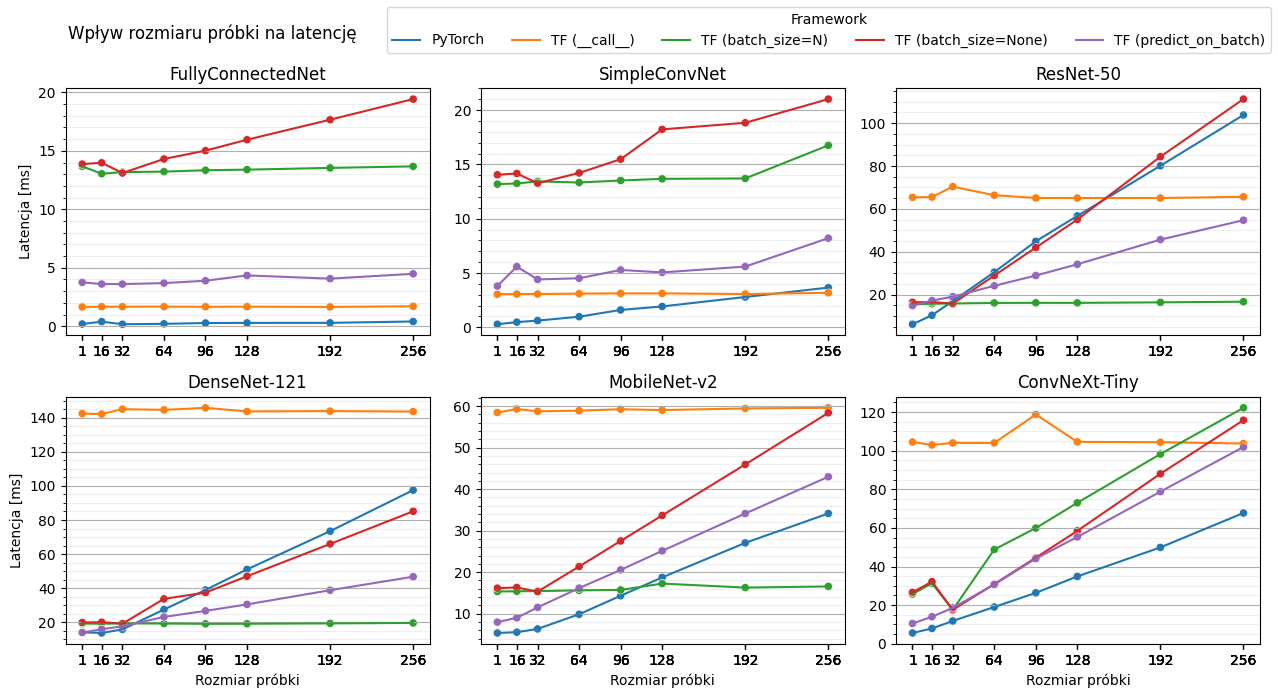

In [3]:
n_models = len(results.model_name.unique())
fig, axes = plt.subplots(2, n_models // 2, figsize=(12.8, 7))
fig.suptitle("Wpływ rozmiaru próbki na latencję", x=0.17, y=0.97)

for i, (ax, model_name) in enumerate(zip(axes.flatten(), MODEL_ORDER[:-2])):
	model_results = results[results.model_name == model_name]
	sns.lineplot(data=model_results, x="batch_size", y="elapsed_time", hue="framework", ax=ax)
	sns.scatterplot(data=model_results, x="batch_size", y="elapsed_time", hue="framework", ax=ax, legend=False)
	set_vertical_grid(ax)
	ax.set_title(model_name)
	ax.set_xticks(model_results.batch_size)
	ax.set_xlabel("Rozmiar próbki" if i >= 3 else "")
	ax.set_ylabel("Latencja [ms]" if i % 3 == 0 else "")
	ax.legend(title="Framework i metoda").set_visible(False)

legend_handles, legend_labels = ax.get_legend_handles_labels()
fig.legend(legend_handles, legend_labels, loc='upper right', title="Framework", ncol=5)
fig.tight_layout(rect=[0, 0, 1, 0.98])

fig.savefig("../paper/plots/5.1-3.png")

po kazdej metodzie `predict` itp w TF wywolywane jest `sync_to_numpy_or_python_type` na tensorze zwrotnym XDDDDD i tego nie da sie obejsc wiec wszystko bedzie mialo pojebana stala czasowa bo przenoszone sa dane z GPU na CPU czy tego chcemy czy nie
nie wiem czemu `__call__` jest taki wolny, zwlaszcza ze dokumentacja podaje ze jest szybszy od `predict` ale badania tego nie potwierdzaja

In [4]:
matlab_32, _, _ = get_results("../results_batch_32", full=False, frameworks={"Matlab": True})
matlab_96, _, _ = get_results("../results_ultimate_1", full=False, frameworks={"Matlab": True})

matlab_32 = matlab_32[matlab_32.model_name != "DCGAN"]
matlab_96 = matlab_96[matlab_96.model_name != "DCGAN"]

matlab_32["bsize"] = "32"
matlab_96["bsize"] = "96"

matlab = pd.concat([matlab_32, matlab_96])

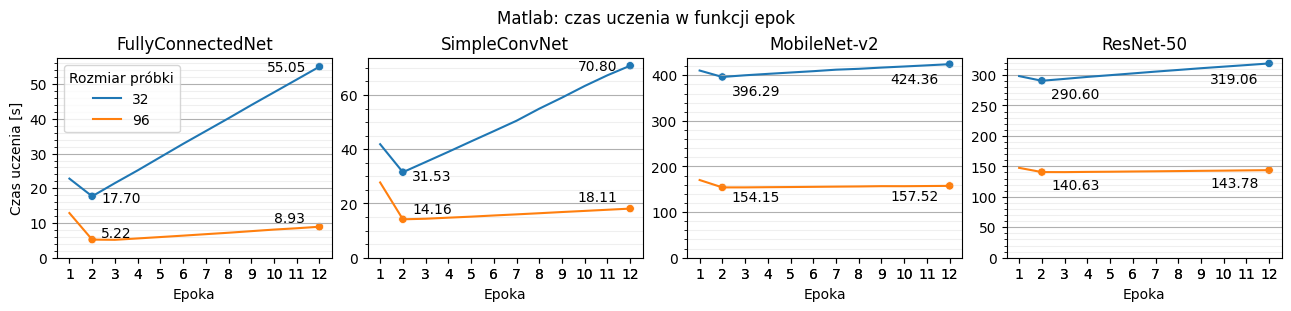

In [5]:
model_names = matlab.model_name.unique()
n_models = len(model_names)
fig, axes = plt.subplots(1, n_models, figsize=(12.8, 3), constrained_layout=True)
fig.suptitle("Matlab: czas uczenia w funkcji epok")

for i, (ax, model_name) in enumerate(zip(axes, model_names)):
	data = matlab[matlab.model_name == model_name]
	p_data = data[data.epoch.isin([2, 12])]
	sns.lineplot(data, x="epoch", y="elapsed_time", hue="bsize", ax=ax, zorder=2)

	ax = sns.scatterplot(p_data, x="epoch", y="elapsed_time", hue="bsize", ax=ax, zorder=1)
	for t, x, y, b in zip(p_data.elapsed_time, p_data.epoch, p_data.elapsed_time, p_data.bsize):
		t = f"{t:.2f}"
		y *= (0.975 if (model_name in ["FullyConnectedNet", "SimpleConvNet"] and x == 12) else 0.9) if b == "32" else (
			1.15 if model_name in ["FullyConnectedNet", "SimpleConvNet"] else 0.8)
		x += 0.4 if x == 2 else -(2 + 0.3 * (len(t) - 4))
		ax.annotate(t, (x, y))

	ax.set_title(model_name)
	ax.set_xlabel("Epoka")
	ax.set_ylabel("Czas uczenia [s]" if i == 0 else "")
	ax.set_ylim(bottom=0)

	ax.legend(*[x[:2] for x in ax.get_legend_handles_labels()], title="Rozmiar próbki")
	if i > 0: ax.get_legend().remove()

	ax.set_xticks(data.epoch)

	ax.grid(axis="y", which="major", zorder=1)
	ax.minorticks_on()
	ax.tick_params(axis='x', which='minor', bottom=False)
	ax.grid(visible=True, axis="y", which="minor", alpha=0.2, zorder=1)

fig.savefig("../paper/plots/5.1-5.png")